# Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Load and Clean Data

In [2]:
# Load the data without parsing dates
df = pd.read_csv('household_power_consumption.txt', sep=';', header=0, low_memory=False)

# Display the shape and first few rows of the dataframe
print(df.shape)
print(df.head())

(1091376, 9)
         Date      Time Global_active_power Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.840   
1  16/12/2006  17:25:00               5.360                 0.436  233.630   
2  16/12/2006  17:26:00               5.374                 0.498  233.290   
3  16/12/2006  17:27:00               5.388                 0.502  233.740   
4  16/12/2006  17:28:00               3.666                 0.528  235.680   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
0           18.400          0.000          1.000            17.0  
1           23.000          0.000          1.000            16.0  
2           23.000          0.000          2.000            17.0  
3           23.000          0.000          1.000            17.0  
4           15.800          0.000          1.000            17.0  


**Handling Duplicates**

In [3]:
# Identify and Print the number duplicate records
print("Number of Duplicated rows: ", df.duplicated().sum())

Number of Duplicated rows:  0


In [4]:
# Convert the date columns
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
df.set_index('datetime', inplace=True)

# Drop the original Date and Time columns if no longer needed
df.drop(columns=['Date', 'Time'], inplace=True)

# Drop duplicated rows
df.drop_duplicates(inplace=True)

# Verify the changes
print(df.shape)
print(df.head())
print("Number of duplicated rows after removal: ", df.duplicated().sum())

(1007983, 7)
                    Global_active_power Global_reactive_power  Voltage  \
datetime                                                                 
2006-12-16 17:24:00               4.216                 0.418  234.840   
2006-12-16 17:25:00               5.360                 0.436  233.630   
2006-12-16 17:26:00               5.374                 0.498  233.290   
2006-12-16 17:27:00               5.388                 0.502  233.740   
2006-12-16 17:28:00               3.666                 0.528  235.680   

                    Global_intensity Sub_metering_1 Sub_metering_2  \
datetime                                                             
2006-12-16 17:24:00           18.400          0.000          1.000   
2006-12-16 17:25:00           23.000          0.000          1.000   
2006-12-16 17:26:00           23.000          0.000          2.000   
2006-12-16 17:27:00           23.000          0.000          1.000   
2006-12-16 17:28:00           15.800          0.

**Handling Missing Data**

In [5]:
df = df.replace('?', np.nan)

# Convert variables to numeric, setting errors='coerce' to handle non-numeric data
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df['Sub_metering_1'] = pd.to_numeric(df['Sub_metering_1'], errors='coerce')
df['Sub_metering_2'] = pd.to_numeric(df['Sub_metering_2'], errors='coerce')
df['Sub_metering_3'] = pd.to_numeric(df['Sub_metering_3'], errors='coerce')

In [6]:
# Check the count of missing/NaN values in each column
round((df.isnull().sum()/df.shape[0])*100,2)

,0
Global_active_power,0.0
Global_reactive_power,0.0
Voltage,0.0
Global_intensity,0.0
Sub_metering_1,0.0
Sub_metering_2,0.0
Sub_metering_3,0.0


In [7]:
# Drop rows with missing values for future datasets
df.dropna(inplace=True)

# Fill NaN values, if any, with the mean of the each column
df['Global_active_power'] = df['Global_active_power'].fillna(df['Global_active_power'].mean())
df['Sub_metering_1'] = df['Sub_metering_1'].fillna(df['Sub_metering_1'].mean())
df['Sub_metering_2'] = df['Sub_metering_2'].fillna(df['Sub_metering_2'].mean())
df['Sub_metering_3'] = df['Sub_metering_3'].fillna(df['Sub_metering_3'].mean())

In [8]:
# Display the count of NaN values in each column after filling
print("NaN values after filling:")
print(df.isnull().sum())

NaN values after filling:
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


In [9]:
# Feature correlation to determine relevant features for Energy Consumption
correlation_matrix = df.corr()
print(correlation_matrix['Global_active_power'].sort_values(ascending=False))

Global_active_power      1.000000
Global_intensity         0.998987
Sub_metering_3           0.608426
Sub_metering_1           0.475390
Sub_metering_2           0.454530
Global_reactive_power    0.214413
Voltage                 -0.390363
Name: Global_active_power, dtype: float64


**Handling Outliers**

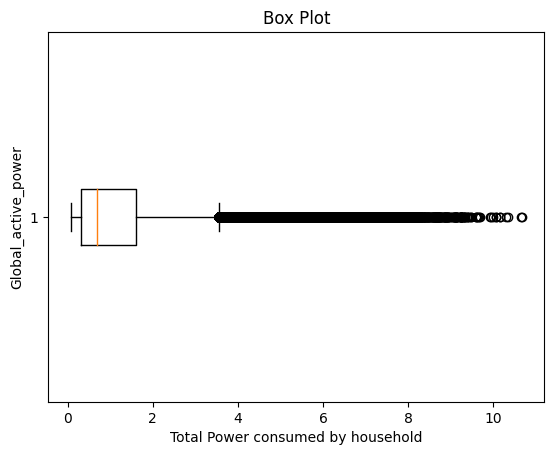

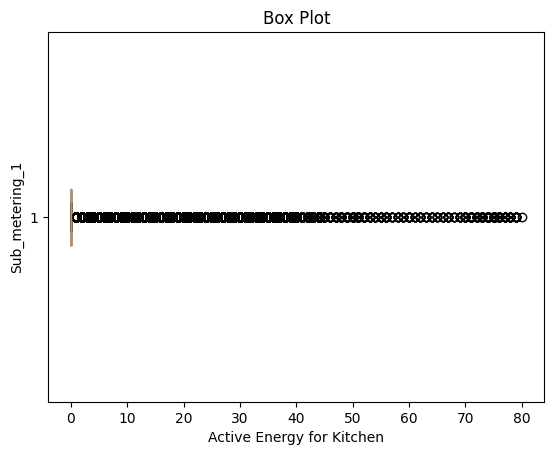

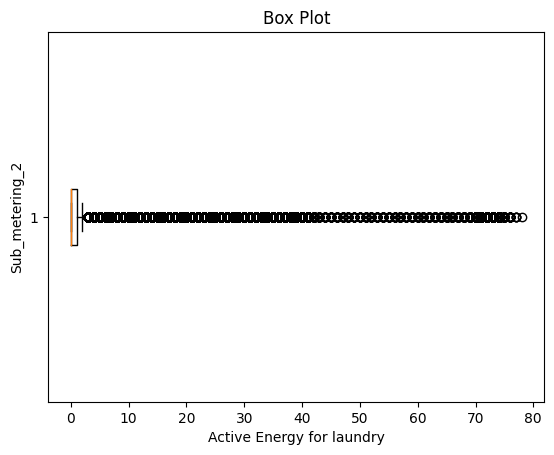

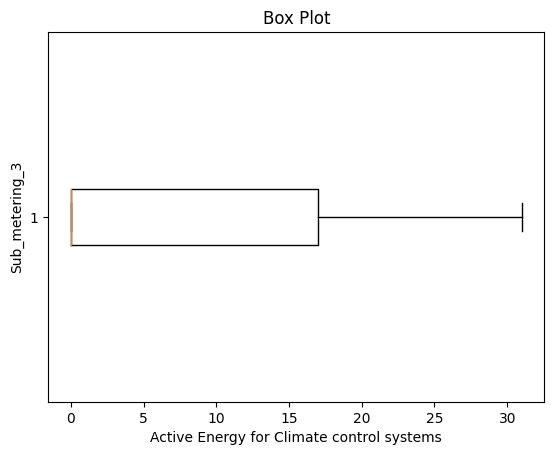

In [10]:
# Identify and Display outliers of relevant features to energy consumption trends
plt.boxplot(df['Global_active_power'], vert=False)
plt.ylabel('Global_active_power')
plt.xlabel('Total Power consumed by household')
plt.title('Box Plot')
plt.show()

plt.boxplot(df['Sub_metering_1'], vert=False)
plt.ylabel('Sub_metering_1')
plt.xlabel('Active Energy for Kitchen')
plt.title('Box Plot')
plt.show()

plt.boxplot(df['Sub_metering_2'], vert=False)
plt.ylabel('Sub_metering_2')
plt.xlabel('Active Energy for laundry')
plt.title('Box Plot')
plt.show()

plt.boxplot(df['Sub_metering_3'], vert=False)
plt.ylabel('Sub_metering_3')
plt.xlabel('Active Energy for Climate control systems')
plt.title('Box Plot')
plt.show()

In [11]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    # Filter out the outliers
    mask = (df[column] >= lower_limit) & (df[column] <= upper_limit)
    return df[mask]

# Apply outlier removal for relevant columns
df = remove_outliers(df, 'Global_active_power')
print("After Global_active_power outlier removal:", df.shape)

df = remove_outliers(df, 'Sub_metering_1')
print("After Sub_metering_1 outlier removal:", df.shape)

df = remove_outliers(df, 'Sub_metering_2')
print("After Sub_metering_2 outlier removal:", df.shape)

After Global_active_power outlier removal: (957473, 7)
After Sub_metering_1 outlier removal: (894803, 7)
After Sub_metering_2 outlier removal: (869841, 7)


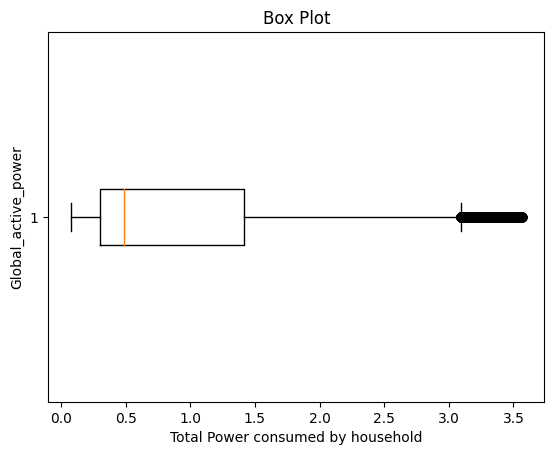

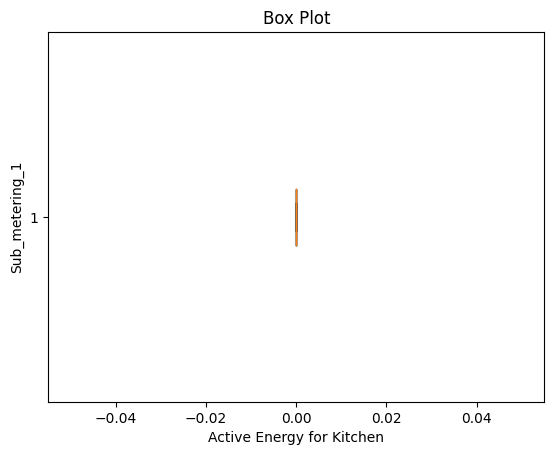

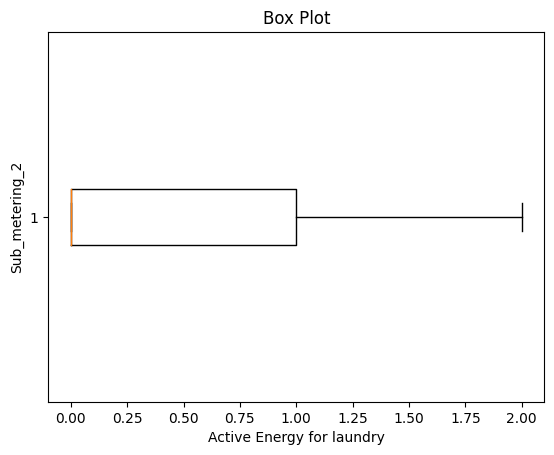

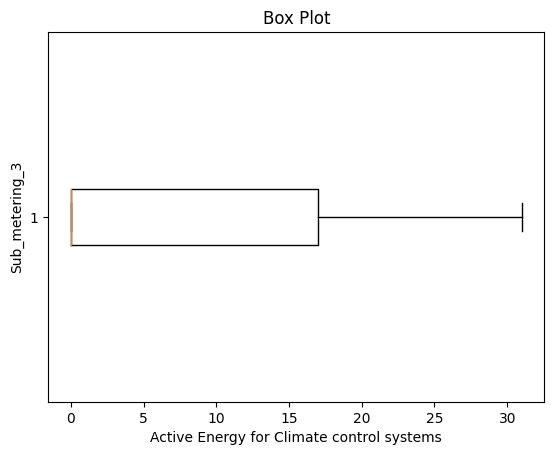

In [12]:
plt.boxplot(df['Global_active_power'], vert=False)
plt.ylabel('Global_active_power')
plt.xlabel('Total Power consumed by household')
plt.title('Box Plot')
plt.show()

plt.boxplot(df['Sub_metering_1'], vert=False)
plt.ylabel('Sub_metering_1')
plt.xlabel('Active Energy for Kitchen')
plt.title('Box Plot')
plt.show()

plt.boxplot(df['Sub_metering_2'], vert=False)
plt.ylabel('Sub_metering_2')
plt.xlabel('Active Energy for laundry')
plt.title('Box Plot')
plt.show()

plt.boxplot(df['Sub_metering_3'], vert=False)
plt.ylabel('Sub_metering_3')
plt.xlabel('Active Energy for Climate control systems')
plt.title('Box Plot')
plt.show()

Data Exploration

In [13]:
# Recalculate the correlation matrix with the cleaned data
correlation_matrix_cleaned = df.corr()
print(correlation_matrix_cleaned['Global_active_power'].sort_values(ascending=False))


Global_active_power      1.000000
Global_intensity         0.998389
Sub_metering_3           0.714214
Global_reactive_power    0.108603
Sub_metering_2          -0.000081
Voltage                 -0.268467
Sub_metering_1                NaN
Name: Global_active_power, dtype: float64


# **Off-peak/Peak Loading Times**

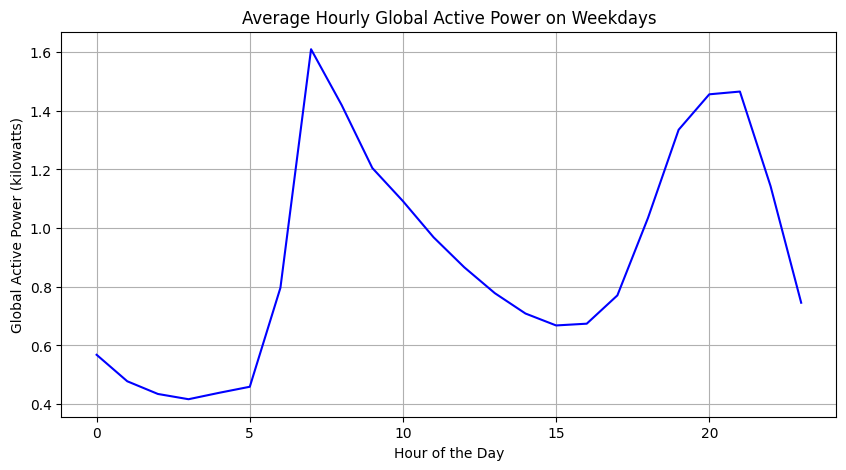

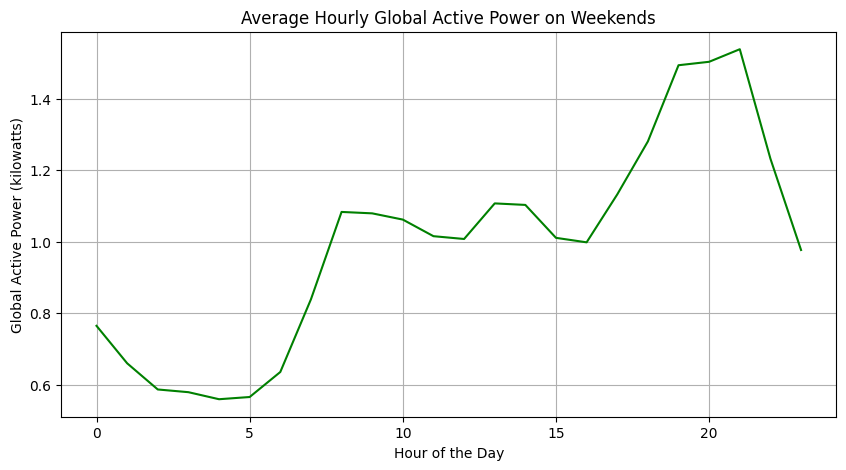

In [14]:
# Feature Engineering: Extract time based features
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

# Separate weekday (0-4) and weekend (5-6) data
weekday_data = df[df['day_of_week'] < 5]
weekend_data = df[df['day_of_week'] >= 5]

# Group data by hour for weekdays and weekends
weekday_consumption = weekday_data.groupby('hour')['Global_active_power'].mean()
weekend_consumption = weekend_data.groupby('hour')['Global_active_power'].mean()

# Plot the average hourly consumption for weekdays
plt.figure(figsize=(10,5))
weekday_consumption.plot(kind='line', label='Weekdays', color='blue')
plt.title('Average Hourly Global Active Power on Weekdays')
plt.xlabel('Hour of the Day')
plt.ylabel('Global Active Power (kilowatts)')
plt.grid(True)
plt.show()

# Plot the average hourly consumption for weekends
plt.figure(figsize=(10,5))
weekend_consumption.plot(kind='line', label='Weekends', color='green')
plt.title('Average Hourly Global Active Power on Weekends')
plt.xlabel('Hour of the Day')
plt.ylabel('Global Active Power (kilowatts)')
plt.grid(True)
plt.show()


# Seasonal Trend Analysis

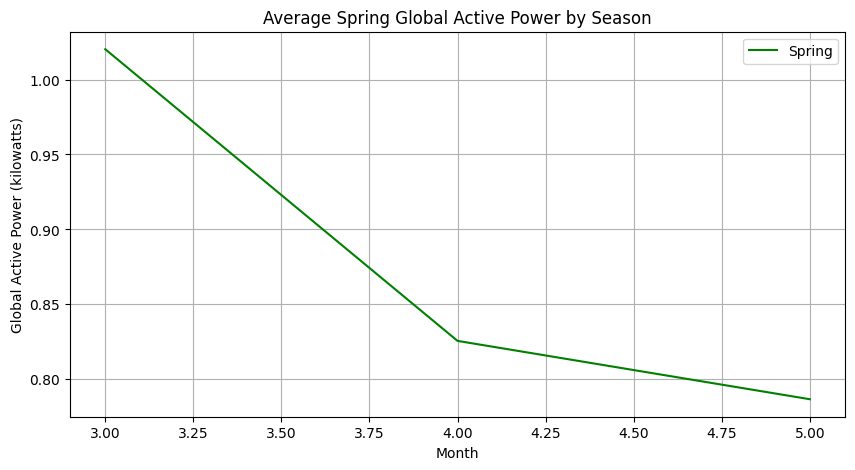

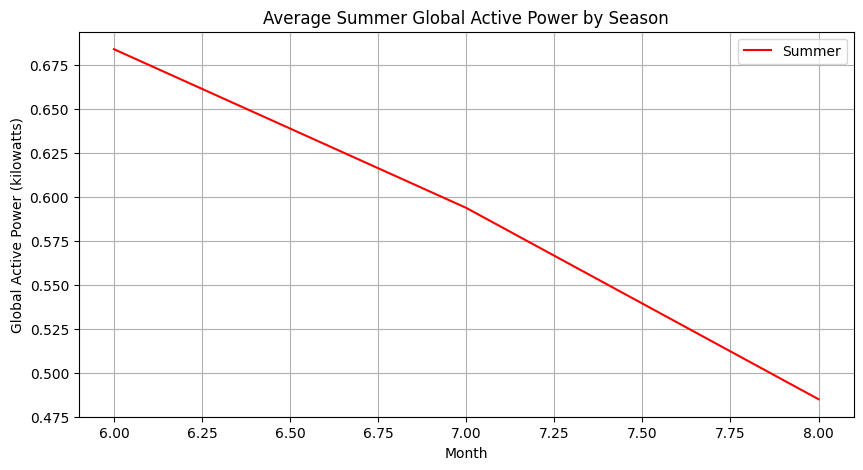

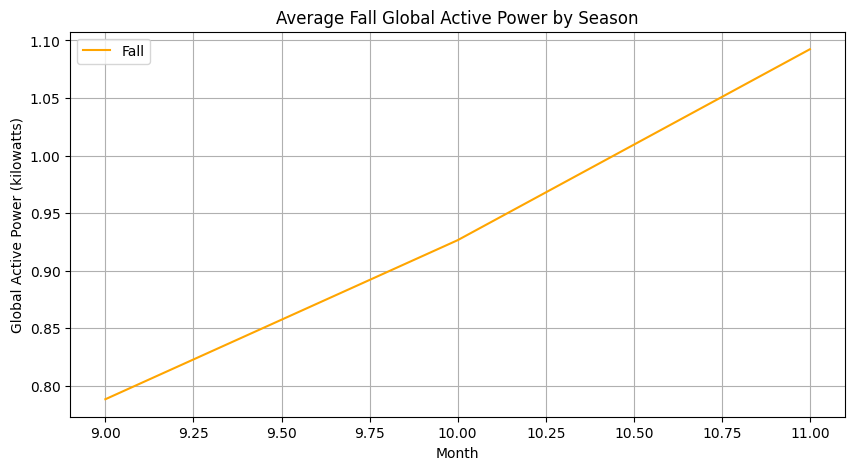

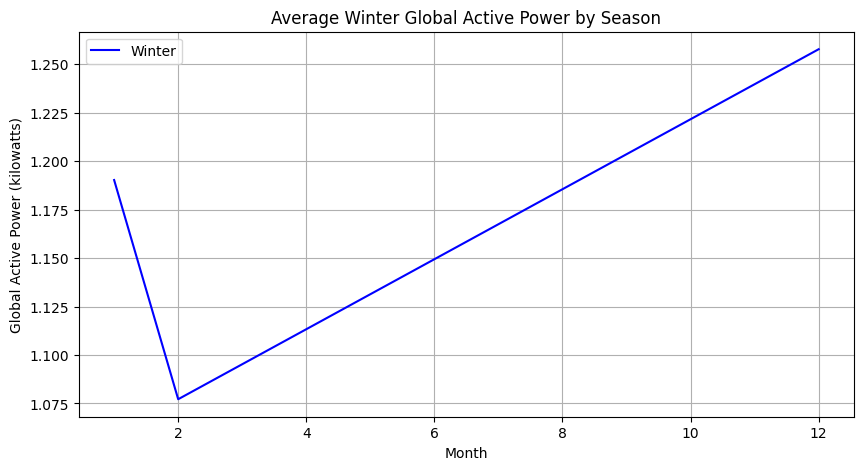

In [16]:
# Extract season based features
df['month'] = df.index.month

# Separate season data
spring_data = df[(df['month'] >= 3) & (df['month'] <= 5)]
summer_data = df[(df['month'] >= 6) & (df['month'] <= 8)]
fall_data = df[(df['month'] >= 9) & (df['month'] <= 11)]
winter_data = df[df['month'].isin([12, 1, 2])]

# Group data by month for seasons
spring_consumption = spring_data.groupby('month')['Global_active_power'].mean()
summer_consumption = summer_data.groupby('month')['Global_active_power'].mean()
fall_consumption = fall_data.groupby('month')['Global_active_power'].mean()
winter_consumption = winter_data.groupby('month')['Global_active_power'].mean()

# Plot the average monthly consumption for spring
plt.figure(figsize=(10,5))
spring_consumption.plot(kind='line', label='Spring', color='green')
plt.title('Average Spring Global Active Power by Season')
plt.xlabel('Month')
plt.ylabel('Global Active Power (kilowatts)')
plt.grid(True)
plt.legend()
plt.show()

# Plot the average monthly consumption for summer
plt.figure(figsize=(10,5))
summer_consumption.plot(kind='line', label='Summer', color='red')
plt.title('Average Summer Global Active Power by Season')
plt.xlabel('Month')
plt.ylabel('Global Active Power (kilowatts)')
plt.grid(True)
plt.legend()
plt.show()

# Plot the average monthly consumption for fall
plt.figure(figsize=(10,5))
fall_consumption.plot(kind='line', label='Fall', color='orange')
plt.title('Average Fall Global Active Power by Season')
plt.xlabel('Month')
plt.ylabel('Global Active Power (kilowatts)')
plt.grid(True)
plt.legend()
plt.show()

# Plot the average monthly consumption for winter
plt.figure(figsize=(10,5))
winter_consumption.plot(kind='line', label='Winter', color='blue')
plt.title('Average Winter Global Active Power by Season')
plt.xlabel('Month')
plt.ylabel('Global Active Power (kilowatts)')
plt.grid(True)
plt.legend()
plt.show()

Normalising/Scaling

In [17]:
scaler = MinMaxScaler()
df[[ 'Global_active_power', 'hour', 'Sub_metering_2', 'Sub_metering_3', 'month']] = scaler.fit_transform(df[[ 'Global_active_power','hour', 'Sub_metering_2', 'Sub_metering_3', 'month']])

In [18]:
# Save cleaned data
df.to_csv('cleaned_power_consumption.csv')

# Predict Energy Consumption

In [ ]:
# Load cleaned data
df = pd.read_csv("cleaned_power_consumption.csv")

print(df.info())
print(df.head())
print(df.describe())
print(df.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1659458 entries, 0 to 1659457
Data columns (total 12 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1659458 non-null  int64  
 1   datetime               1659458 non-null  object 
 2   Global_active_power    1659458 non-null  float64
 3   Global_reactive_power  1659458 non-null  float64
 4   Voltage                1659458 non-null  float64
 5   Global_intensity       1659458 non-null  float64
 6   Sub_metering_1         1659458 non-null  float64
 7   Sub_metering_2         1659458 non-null  float64
 8   Sub_metering_3         1659458 non-null  float64
 9   hour                   1659458 non-null  float64
 10  day_of_week            1659458 non-null  int64  
 11  month                  1659458 non-null  float64
dtypes: float64(9), int64(2), object(1)
memory usage: 151.9+ MB
None
   Unnamed: 0             datetime  Global_active_power  \
0  

In [19]:
# Split the data into train and test sets
train, test = train_test_split(df, test_size = 0.2, random_state = 42)

In [20]:
X = train[['Sub_metering_3', 'hour', 'day_of_week', 'month']]
y = train['Global_active_power']

In [21]:
# Initialise and fit model
model = RandomForestRegressor(n_estimators = 100, random_state = 42)
model.fit(X, y)

RandomForestRegressor(random_state=42)

In [22]:
# Prediction
X_test = test[['Sub_metering_3', 'hour', 'day_of_week', 'month']]
y_test = test['Global_active_power']

In [23]:
# Prediction
y_pred = model.predict(X_test)

In [24]:
model_accuracy = model.score(X_test, y_test)
print("Model Accuracy:", model_accuracy)

Model Accuracy: 0.7355327933154322


In [25]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

for feature, importance in zip(X.columns, model.feature_importances_):
    print(f"{feature}: {importance}")

Mean Squared Error: 0.013049060002104953
R-squared: 0.7355327933154322
Sub_metering_3: 0.710503236369808
hour: 0.15084949416857668
day_of_week: 0.04531284900995904
month: 0.09333442045165635
